# Introduction

Since the modern energy market is a very complex system there is a need for regularization within the system. In order to protect individual sections of a distribuiton or transmission network from an overload a curtailment of the energy fed in becomes necessary. This overall management of the failure work is called EinsMan. To predict this regulated failure work is the main goal of this project.

In this notebook different different plots were made to explore the data.

## Variables

 
|Variable|Description|
|:-------|:--------|
|dswrf_sfc_wm2 | Net downward shortwave radiation flux|
|gust_sfc_ms | Wind gust surface (Böe)|
|hpbl_sfc_m | Planetary boundary layer height|
|msl_ms_pa | Mean sea level pressure|
|pottemp_80mto0m_K | Potential temperature difference between 80m and 0m|
|q_2m_1 | Specific humudity in 2 m height|
|q_pfg30_1 | Specific humidity mean over first 30 hPa (~250m)|
|r_pl925_% | Relative humidity in 925 hPa pressure level|
|r_pl950_% | Relative humidity in 950 hPa pressure level |
|shtfl_sfc_wm2 | Net sensible heat flux (conductive heat flux from the Earth's surface to the atmosphere)|
|t_100m_k | Temperature in 100 m height in Kelvin|
|t_2m_k | Temperature in 2 m height in Kelvin|
|t_pfg30_k | Temperature mean ober first 30 hPa (~250m) in Kelvin |
|tcclow_sfc_% | Total Cloud Cover, low level clouds (0km - 2km height)|
|tccmedium_sfc_% | Total Cloud Cover, medium level clouds (2km - 7km height)|
|wdir_100m_dn | wind direction in 100 m height in in degrees|
|wdir_10m_dn | wind direction in 10 m height in in degrees|
|wdir_pfg30_dn | wind direction mean over first 30 hPa (~250m) in degrees|
|wdir_pl925_dn | wind direction in 925 hPa pressure level in degrees|
|wsp_100m_ms | wind speed in 100 m height in meters/second|
|wsp_10m_ms | wind speed in 10 m height in meters/second |
|wsp_pfg30_ms | wind speed mean over first 30 hPa (~250m) in meters/second|
|wsp_pl925_ms | wind speed in 925 hPa pressure leben in meters/second|
|created_on | date and 24 hours divided in quarters|
|azimuth | shows the rotation of the wind turbine|
|elevation | heights of the sun|

In [1]:
reset -fs

# Loading Modules and Datasets

In [44]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import urllib.request
import time
from datetime import datetime
import requests

import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [3]:
# reading in the first dataframe
with open('griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_fin = u.load()

In [4]:
# rename columns which contains symbols
df_fin = df_fin.rename(columns={'r_pl925_%': 'r_pl925_perc','r_pl950_%': 'r_pl950_perc',
                        'tcclow_sfc_%': 'tcclow_sfc_perc','tccmedium_sfc_%': 'tccmedium_sfc_perc'})
# converting to actual timezone
df_fin.index = df_fin.index.tz_localize(None).to_series(keep_tz=True)

# resampling to a time range of 15 minutes and interpolate between the hourly values
df_fin = df_fin.resample('10min', axis='index').interpolate()
df_fin = df_fin.fillna(method='ffill')

# creating columns with name of the day and month
df_fin['day_name'] = df_fin.index.day_name()
df_fin['day_name'] = df_fin['day_name'].astype('category')
df_fin['month_name'] = df_fin.index.month_name()
df_fin['month_name'] = df_fin['month_name'].astype('category')

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

The 'keep_tz' keyword in DatetimeIndex.to_series is deprecated and will be removed in a future version.  You can stop passing 'keep_tz' to silence this warning.



In [5]:
# reading in the second dataframe
with open('obs_20180101_20190625_03_final_normed.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_norm = u.load()


In [6]:
# converting to the same timezone as the first dataframe
df_norm.index = df_norm.index.tz_localize(None).to_series(keep_tz=True)

# resample 
# df_norm = df_norm.resample('H').mean()

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

The 'keep_tz' keyword in DatetimeIndex.to_series is deprecated and will be removed in a future version.  You can stop passing 'keep_tz' to silence this warning.



In [7]:
# combining both dataframes to have one to work in
df = pd.concat([df_norm,df_fin], axis=1)

In [8]:
# Showing all columns
df.columns

Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k', 't_pfg30_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pfg30_dn', 'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms',
       'wsp_pfg30_ms', 'wsp_pl925_ms', 'created_on', 'azimuth', 'elevation',
       'day_name', 'month_name'],
      dtype='object')

In [9]:
# testing if there are any missing values
print(df_norm[df_norm.isnull().any(axis=1)])
print(df_fin[df_fin.isnull().any(axis=1)])

Empty DataFrame
Columns: [power_mw_obsnorm, power_available_mw_obsnorm, target_losses_norm]
Index: []
Empty DataFrame
Columns: [dswrf_sfc_wm2, gust_sfc_ms, hpbl_sfc_m, msl_ms_pa, pottemp_80mto0m_K, q_2m_1, q_pfg30_1, r_pl925_perc, r_pl950_perc, shtfl_sfc_wm2, t_100m_k, t_2m_k, t_pfg30_k, tcclow_sfc_perc, tccmedium_sfc_perc, wdir_100m_dn, wdir_10m_dn, wdir_pfg30_dn, wdir_pl925_dn, wsp_100m_ms, wsp_10m_ms, wsp_pfg30_ms, wsp_pl925_ms, created_on, azimuth, elevation, day_name, month_name]
Index: []

[0 rows x 28 columns]


In [10]:
# display first five rows
df.head()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,...,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,day_name,month_name
2018-01-01 00:00:00,0.330269,0.450934,0.120665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2018-01-01 00:10:00,0.339204,0.457539,0.118335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2018-01-01 00:20:00,0.336993,0.456577,0.119584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2018-01-01 00:30:00,0.337858,0.462447,0.124589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2018-01-01 00:40:00,0.353646,0.483538,0.129892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [11]:
# display last 5 rows
df.tail()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,...,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,day_name,month_name
2019-08-26 17:20:00,NaN,NaN,NaN,171.166667,7.348251,268.134119,101818.658333,1.080648,0.013093,0.011958,...,307.724320,6.825205,3.777153,6.755940,5.551564,2019-08-23 18:00:00+00:00,276.433411,8.961449,Monday,August
2019-08-26 17:30:00,NaN,NaN,NaN,148.250000,7.523909,254.984092,101818.190625,1.260224,0.013000,0.011938,...,307.997973,6.992995,3.792833,6.920449,5.573614,2019-08-23 18:00:00+00:00,278.341248,7.412167,Monday,August
2019-08-26 17:40:00,NaN,NaN,NaN,125.333333,7.699568,241.834064,101817.722917,1.439800,0.012907,0.011918,...,308.271626,7.160786,3.808514,7.084957,5.595664,2019-08-23 18:00:00+00:00,280.249115,5.862885,Monday,August
2019-08-26 17:50:00,NaN,NaN,NaN,102.416667,7.875226,228.684036,101817.255208,1.619376,0.012813,0.011898,...,308.545278,7.328576,3.824194,7.249466,5.617714,2019-08-23 18:00:00+00:00,282.156952,4.313603,Monday,August
2019-08-26 18:00:00,NaN,NaN,NaN,79.500000,8.050885,215.534009,101816.787500,1.798953,0.012720,0.011877,...,308.818931,7.496367,3.839874,7.413974,5.639764,2019-08-23 18:00:00+00:00,284.064789,2.764322,Monday,August


In [12]:
# get an overview of the data
df.describe()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,...,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation
count,70710.000000,70710.000000,70710.000000,86761.000000,86761.000000,86761.000000,86761.000000,86761.000000,86761.000000,86761.000000,...,86761.000000,86761.000000,86761.000000,86761.000000,86761.000000,86761.000000,86761.000000,86761.000000,86761.000000,86761.000000
mean,0.204310,0.274691,0.070381,155.073697,7.934670,548.778898,101510.221624,0.742654,0.006474,0.006155,...,162.240928,162.200287,161.840275,154.310791,7.464113,4.404233,7.343915,10.063736,182.064011,2.409630
std,0.162364,0.264172,0.128426,227.794197,4.040885,422.741503,994.560396,1.160393,0.002728,0.002535,...,98.322151,98.902271,98.207814,97.276679,3.313623,2.066879,3.270329,5.253702,98.801285,30.262106
min,0.000000,0.000073,0.000049,0.000000,0.517106,21.333019,97637.887500,-2.431875,0.000993,0.000939,...,1.065702,1.605544,0.878477,1.231885,0.558441,0.389727,0.515088,0.338407,8.330822,-62.201588
25%,0.065503,0.074167,0.005369,0.000000,4.701628,202.659974,100966.956250,-0.119197,0.004248,0.004073,...,78.707822,77.482945,78.689569,76.112788,5.193411,2.893507,5.099482,6.088770,93.259331,-19.192339
50%,0.166234,0.181165,0.014100,17.500000,7.641678,454.544277,101563.740000,0.640160,0.006125,0.005899,...,130.930023,129.250575,130.696268,124.651594,7.138825,4.023969,7.024683,9.347689,182.282166,2.380670
75%,0.320650,0.391951,0.056041,245.833333,10.615981,817.397208,102138.173333,1.496410,0.008505,0.008037,...,260.371031,258.737944,260.351122,252.963331,9.232503,5.618008,9.102245,13.125679,270.033234,24.905815
max,0.801717,1.019565,0.779721,885.500000,24.316044,2519.267852,104261.237500,4.514006,0.016743,0.014403,...,359.180650,358.364902,359.093417,359.693548,23.256653,14.571061,23.972086,30.798095,358.682526,62.103596


# Data Cleaning

In [13]:
# drop rows with NaN, since both datasets don't have the same timeframe
df = df.dropna()
df

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,...,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,day_name,month_name
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,...,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894,Monday,January
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,...,60.237190,16.589409,9.804977,16.657162,21.955989,2018-01-01 00:00:00+00:00,113.717751,-10.743970,Monday,January
2018-01-01 06:20:00,0.500030,0.905168,0.405137,0.0,16.720270,1350.826273,99227.979167,0.549156,0.005072,0.004815,...,61.511338,16.630528,9.837206,16.692246,21.948260,2018-01-01 00:00:00+00:00,115.554543,-9.355046,Monday,January
2018-01-01 06:30:00,0.436176,0.918136,0.481961,0.0,16.691888,1351.275581,99235.937500,0.544055,0.005055,0.004796,...,62.785487,16.671646,9.869435,16.727331,21.940530,2018-01-01 00:00:00+00:00,117.391335,-7.966123,Monday,January
2018-01-01 06:40:00,0.423738,0.920801,0.497063,0.0,16.663507,1351.724889,99243.895833,0.538955,0.005038,0.004777,...,64.059635,16.712765,9.901665,16.762416,21.932800,2018-01-01 00:00:00+00:00,119.228127,-6.577199,Monday,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-25 01:10:00,0.290788,0.317405,0.026618,0.0,10.359493,243.857254,102171.072917,2.345096,0.009911,0.009590,...,343.567564,8.744555,4.072132,8.883419,9.956735,2019-06-24 18:00:00+00:00,25.039539,-11.744265,Tuesday,June
2019-06-25 01:20:00,0.297746,0.330850,0.033104,0.0,10.198118,237.270356,102161.183333,2.351379,0.009859,0.009548,...,343.433284,8.710395,4.049734,8.842701,9.802114,2019-06-24 18:00:00+00:00,27.223625,-10.975300,Tuesday,June
2019-06-25 01:30:00,0.310582,0.341660,0.031078,0.0,10.036744,230.683457,102151.293750,2.357663,0.009808,0.009506,...,343.299005,8.676235,4.027335,8.801982,9.647494,2019-06-24 18:00:00+00:00,29.407711,-10.206336,Tuesday,June
2019-06-25 01:40:00,0.308457,0.338645,0.030189,0.0,9.875370,224.096558,102141.404167,2.363946,0.009756,0.009464,...,343.164726,8.642075,4.004936,8.761264,9.492873,2019-06-24 18:00:00+00:00,31.591799,-9.437372,Tuesday,June


In [14]:
# mean and max difference between windspeed in 100m height and after first 30 hPA
diff_wsp = (abs(df['wsp_pfg30_ms']-df['wsp_100m_ms']))
diff_wsp = pd.DataFrame(diff_wsp)
print(diff_wsp[0].mean())
print(diff_wsp[0].max())

# mean and max difference between wind direction in 100m height and after first 30 hPA
diff_wdir = (df['wdir_pfg30_dn']-df['wdir_100m_dn'])
diff_wdir = pd.DataFrame(diff_wdir)
print(diff_wdir[0].mean())
print(diff_wdir[0].max())

# mean and max difference between temperatures in 100m height and after first 30 hPA
diff_t = (df['t_pfg30_k']-df['t_100m_k'])
diff_t = pd.DataFrame(diff_t)
print(diff_t[0].mean())
print(diff_t[0].max())

# dropping columns for after first 30 hPa since 100m is nearly the same height
if 'wsp_pfg30_ms' in df.columns:
    df.pop('wsp_pfg30_ms')
    df.pop('wdir_pfg30_dn')
    df.pop('t_pfg30_k')
    print(df.columns)

0.15290214960235474
0.7652005515770703
-0.46037204631724776
91.2075218095992
-0.0699522423858068
0.75
Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms',
       'created_on', 'azimuth', 'elevation', 'day_name', 'month_name'],
      dtype='object')


In [15]:
# encoding the day of the week as well as the month
encoder = preprocessing.OneHotEncoder(dtype=np.int,categories=[['Monday','Tuesday','Wednesday','Thursday',
                                                                'Friday','Saturday','Sunday'],['January',
                                                                'February','March','April','May','June',
                                                                'July','August','September','October',
                                                                'November','December']])
onehotfeat = ['day_name','month_name']
for i in onehotfeat:
    cat_feat = pd.DataFrame(encoder.fit_transform(df[['day_name','month_name']]).toarray(),
                            columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',
                                     'January','February','March','April','May','June','July','August',
                                     'September','October','November','December'])
cat_feat.index = df.index
df = pd.concat([df,cat_feat], axis=1)

# Data Exploration

## Correlation matrix and heatmap

In [16]:
# check duplicates
df[df.index.duplicated()]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,...,March,April,May,June,July,August,September,October,November,December


In [17]:
df_corr = pd.DataFrame(df)

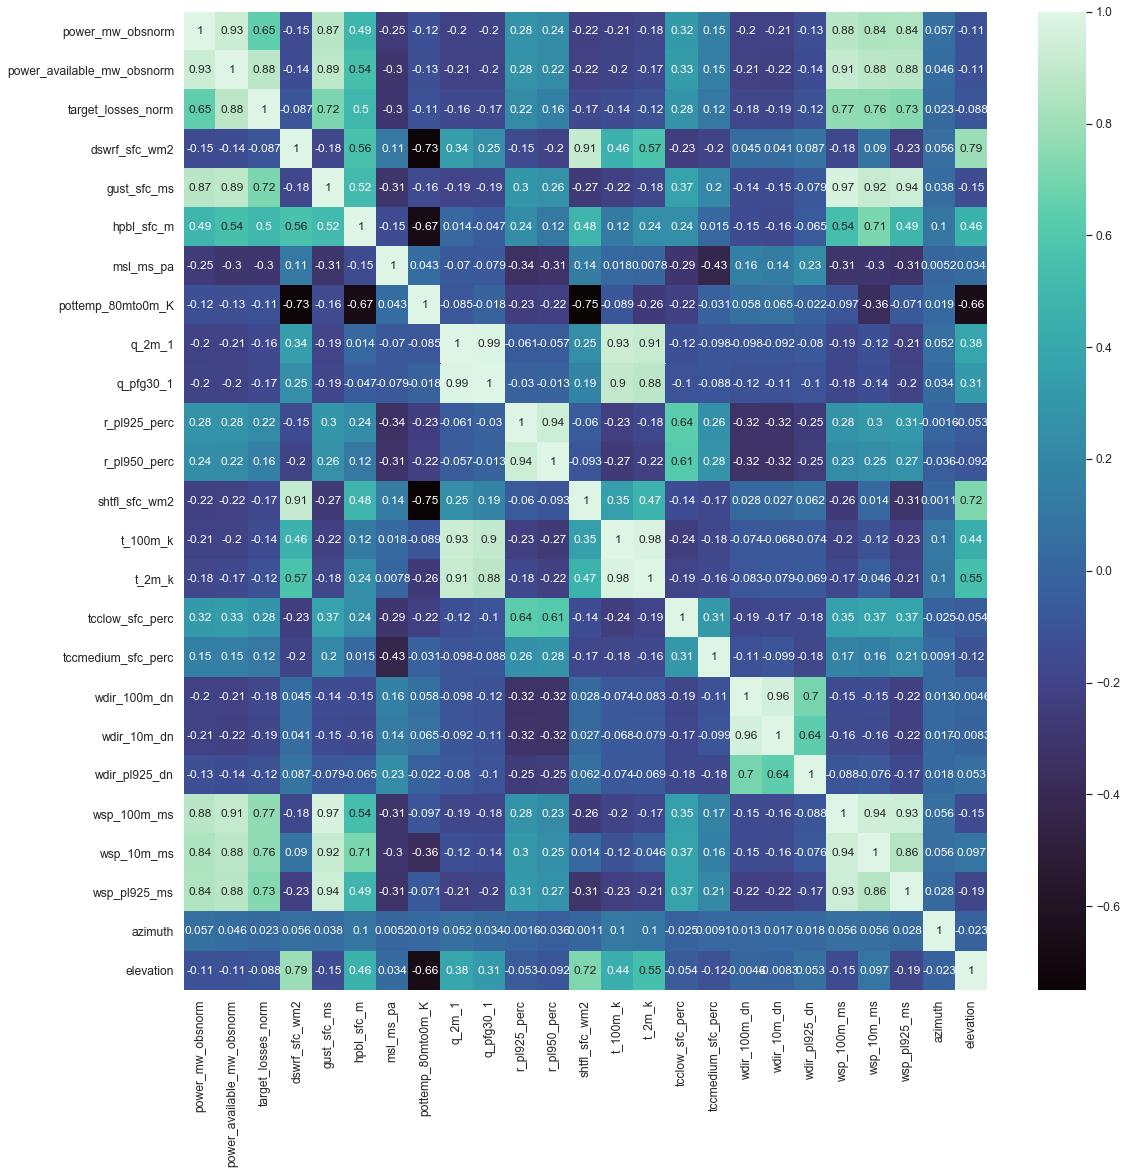

In [18]:
# correalation matrix between each column
plt.figure(figsize=(18,18))
sns.set(font_scale=1.1)
sns.heatmap(df.iloc[:,range(28)].corr(), cmap='mako', annot=True, annot_kws={'size':12})
plt.show()

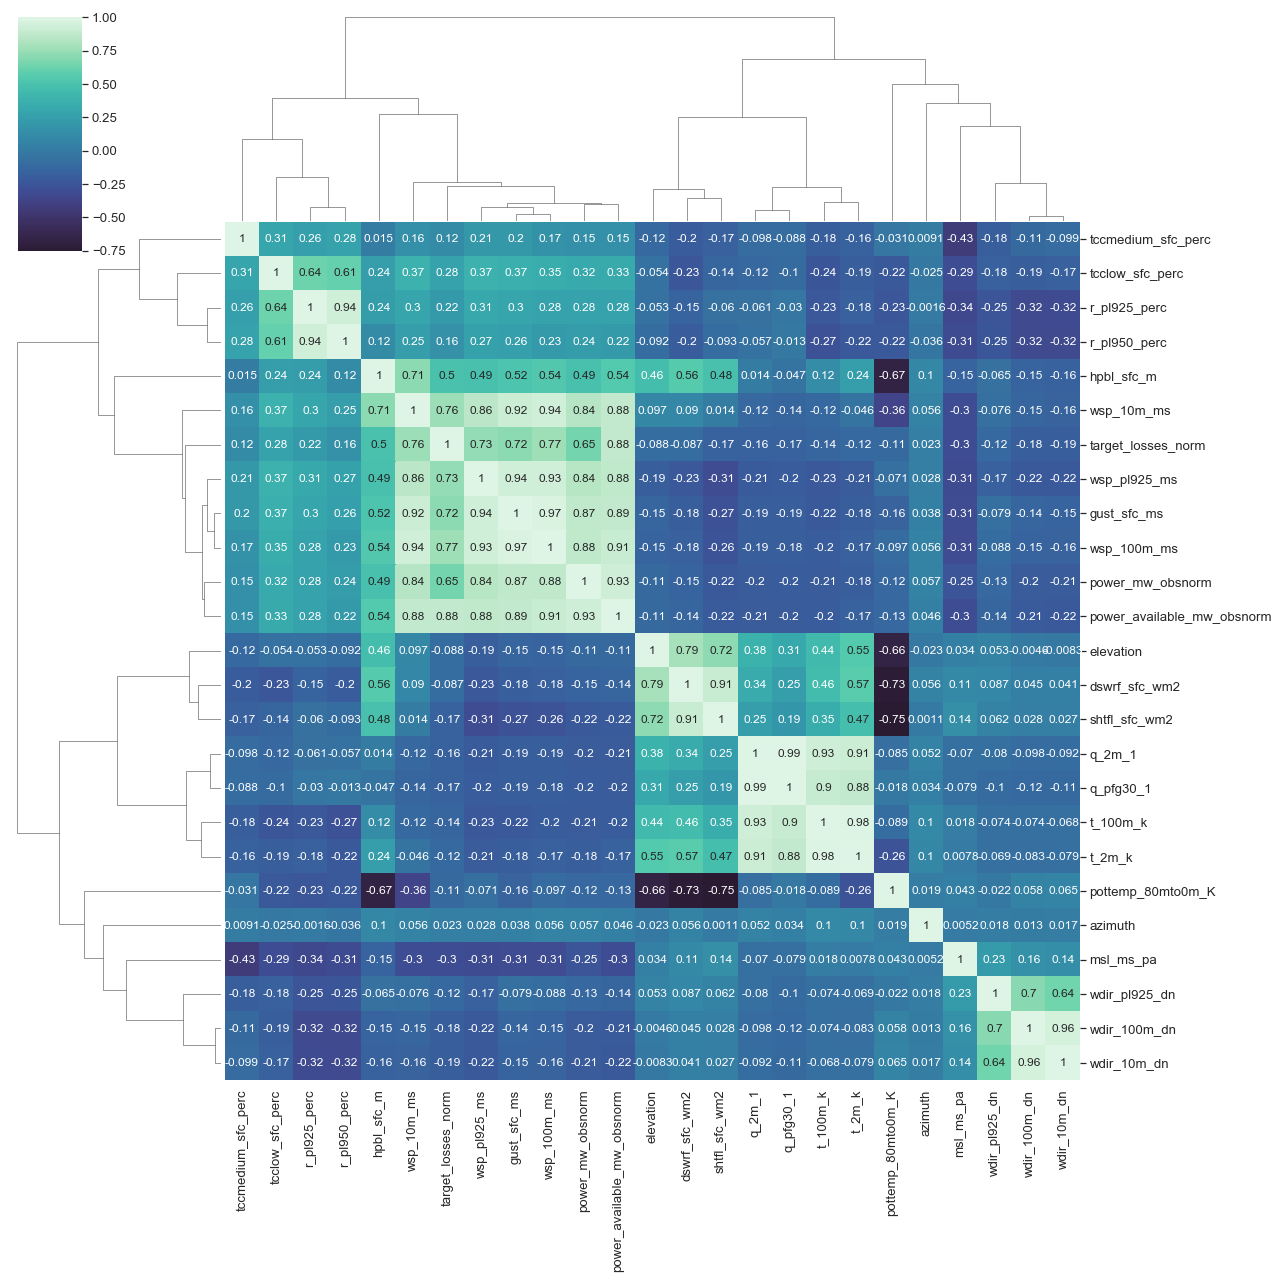

In [19]:
# correlation map as a cluster map
sns.set(font_scale=1.2)
sns.clustermap(df.iloc[:,range(28)].corr(), cmap='mako', center=0.0, annot=True, annot_kws={'size': 12}, figsize=(18,18))
plt.show()

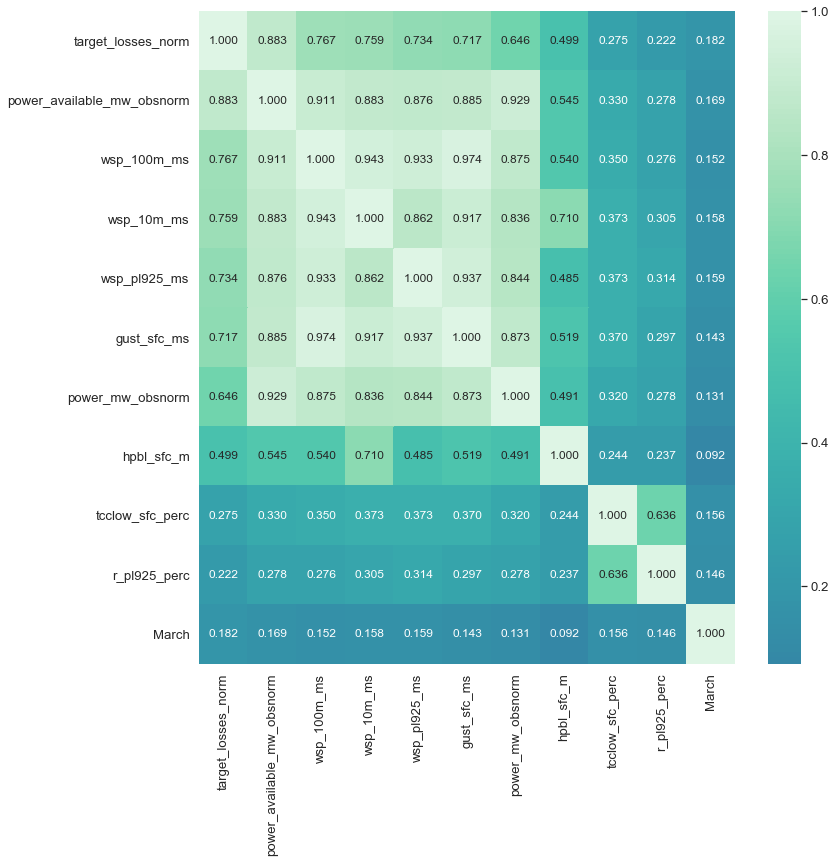

In [20]:

k = 11 #number of variables for heatmap
cols_corr_mat = df.corr().nlargest(k, 'target_losses_norm')['target_losses_norm'].index
cm = np.corrcoef(df[cols_corr_mat].dropna().values.T)
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, annot=True, fmt='.3f', annot_kws={'size': 12},
                 yticklabels=cols_corr_mat.values, xticklabels=cols_corr_mat.values, cmap='mako', center=0.0)
plt.show()

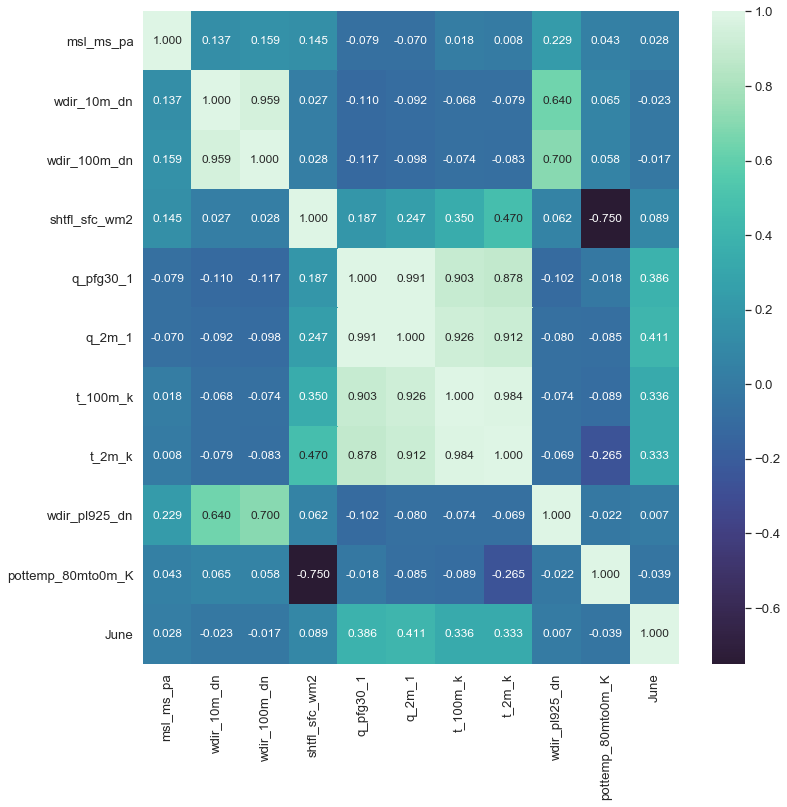

In [21]:

k = 11 #number of variables for heatmap
cols_corr_mat = df.corr().nsmallest(k, 'target_losses_norm')['target_losses_norm'].index
cm = np.corrcoef(df[cols_corr_mat].dropna().values.T)
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, annot=True, fmt='.3f', annot_kws={'size': 12},
                 yticklabels=cols_corr_mat.values, xticklabels=cols_corr_mat.values, cmap='mako', center=0.0)
plt.show()

## Explore data

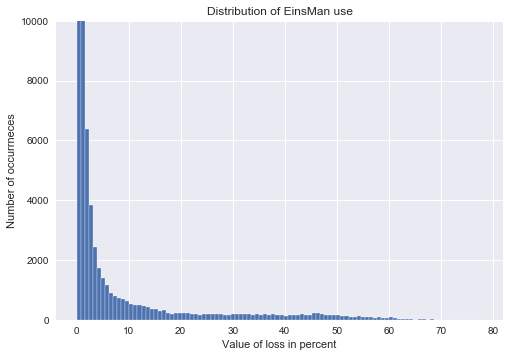

In [22]:
# distribution of target_losses_norm
plt.style.use('seaborn')
(df['target_losses_norm']*100).hist(bins=100)
plt.title('Distribution of EinsMan use')
plt.ylim(0,10000)
plt.ylabel('Number of occurrneces')
plt.xlabel('Value of loss in percent')
plt.show()

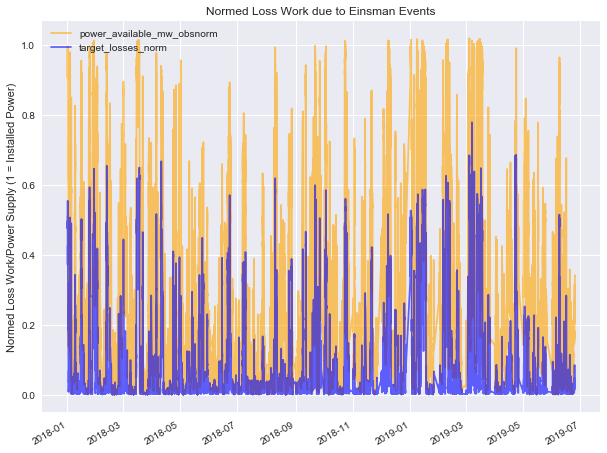

In [23]:
# Plot time series of loss work and available power:
plt.style.use('seaborn')
plt.figure(figsize=(10,8))
df.power_available_mw_obsnorm.plot(c='orange', alpha=0.6)
df.target_losses_norm.plot(c='blue', alpha=0.6)
plt.legend(loc='upper left')
plt.title('Normed Loss Work due to Einsman Events')
plt.ylabel('Normed Loss Work/Power Supply (1 = Installed Power)')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

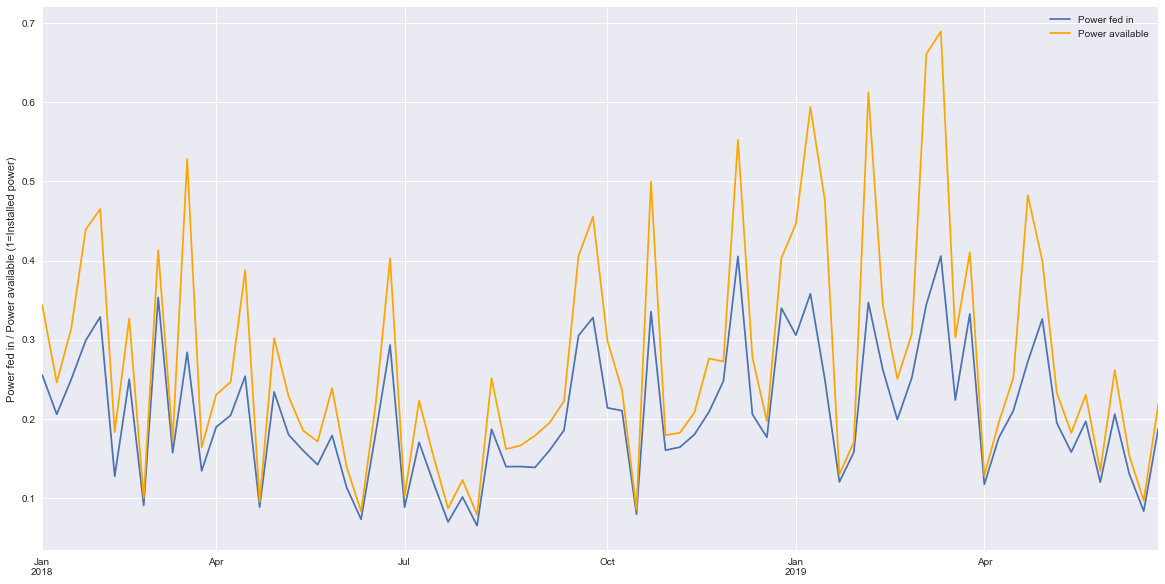

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
avg_pow = df['power_mw_obsnorm'].resample('W').mean()
avg_pot = df['power_available_mw_obsnorm'].resample('W').mean()
avg_pow.plot(label='Power fed in',color='b')
avg_pot.plot(label='Power available',color='orange')
plt.ylabel('Power fed in / Power available (1=Installed power)')
plt.legend()
plt.show

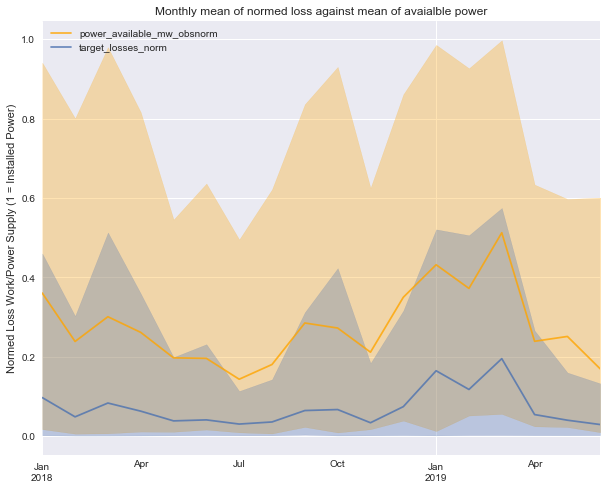

In [25]:
# monthly mean of normed losses due to EinsMan cases against monthly mean of available power
upper1 = df.power_available_mw_obsnorm.resample('M').apply(lambda x: x.quantile(0.95))
lower1 = df.power_available_mw_obsnorm.resample('M').apply(lambda x: x.quantile(0.05))

upper2 = df.target_losses_norm.resample('M').apply(lambda x: x.quantile(0.95))
lower2 = df.target_losses_norm.resample('M').apply(lambda x: x.quantile(0.05))


plt.style.use('seaborn')
plt.figure(figsize=(10,8))
df.power_available_mw_obsnorm.resample('M').mean().plot(c='orange', alpha=0.8)
plt.fill_between(upper1.index, lower1, upper1, color='orange', alpha=0.3)
df.target_losses_norm.resample('M').mean().plot(c='b', alpha=0.8)
plt.fill_between(upper2.index, lower2, upper2, color='b', alpha=0.3)

plt.legend(loc='upper left')
plt.title('Monthly mean of normed loss against mean of avaialble power')
plt.ylabel('Normed Loss Work/Power Supply (1 = Installed Power)')
plt.show()

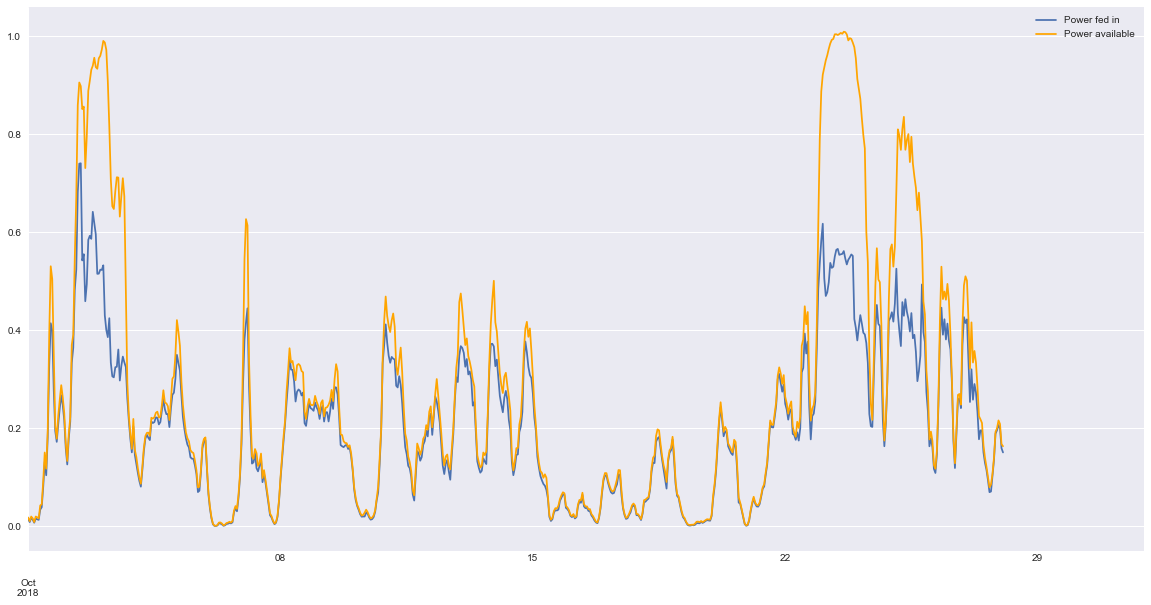

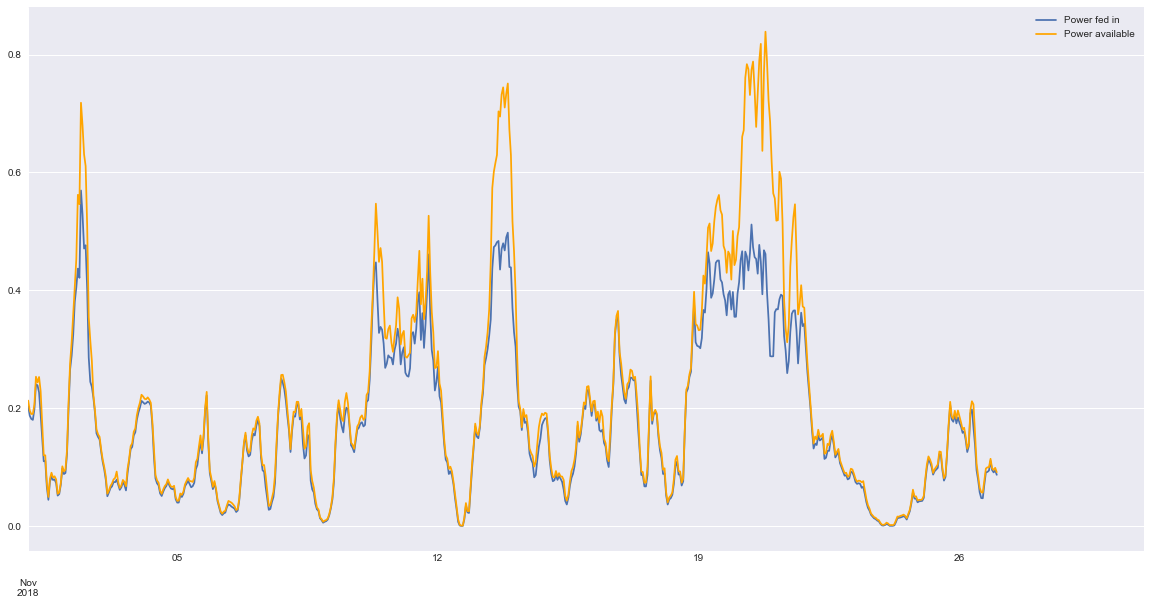

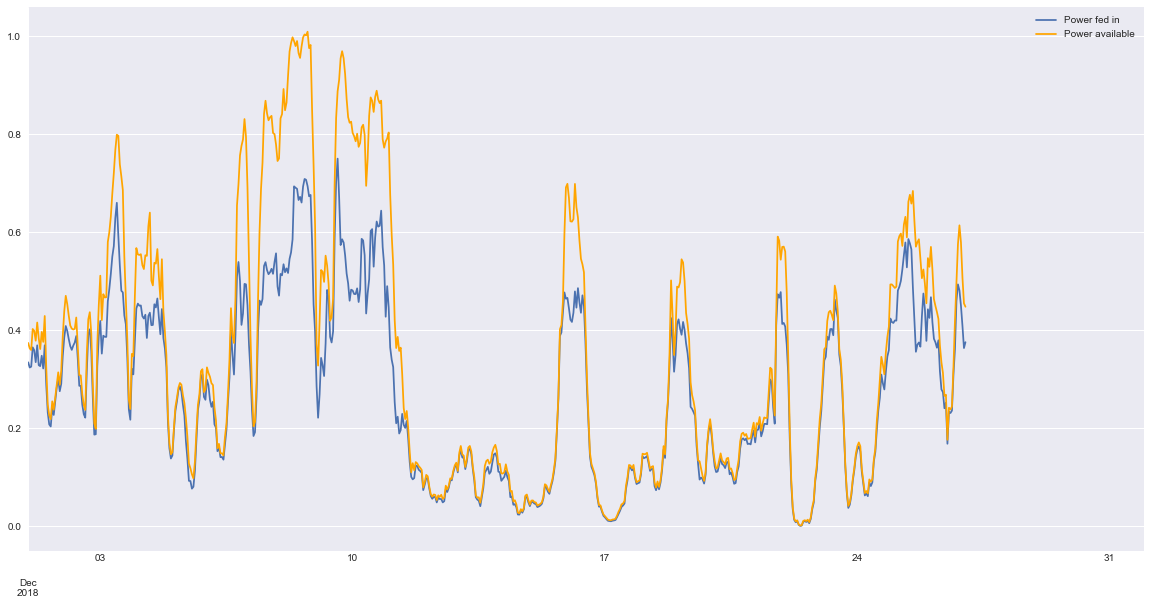

In [26]:
month = ['October','November', 'December'
        ]
for i in month:
    fig, ax = plt.subplots(figsize=(20,10))
    data = df.query('{} == 1'.format(i))
    avg_pow = data['power_mw_obsnorm'].resample('H').mean()
    avg_pot = data['power_available_mw_obsnorm'].resample('H').mean()
    avg_pow.plot(label='Power fed in',color = 'b',legend=True)
    avg_pot.plot(label='Power available',color='orange',legend=True)
    plt.show

<function matplotlib.pyplot.show(*args, **kw)>

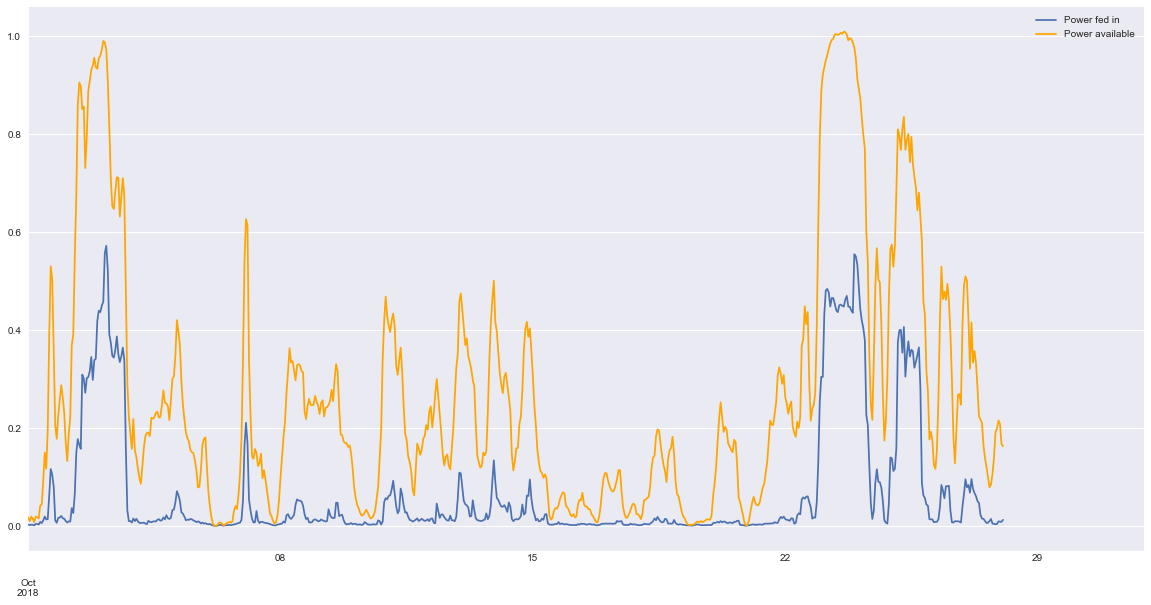

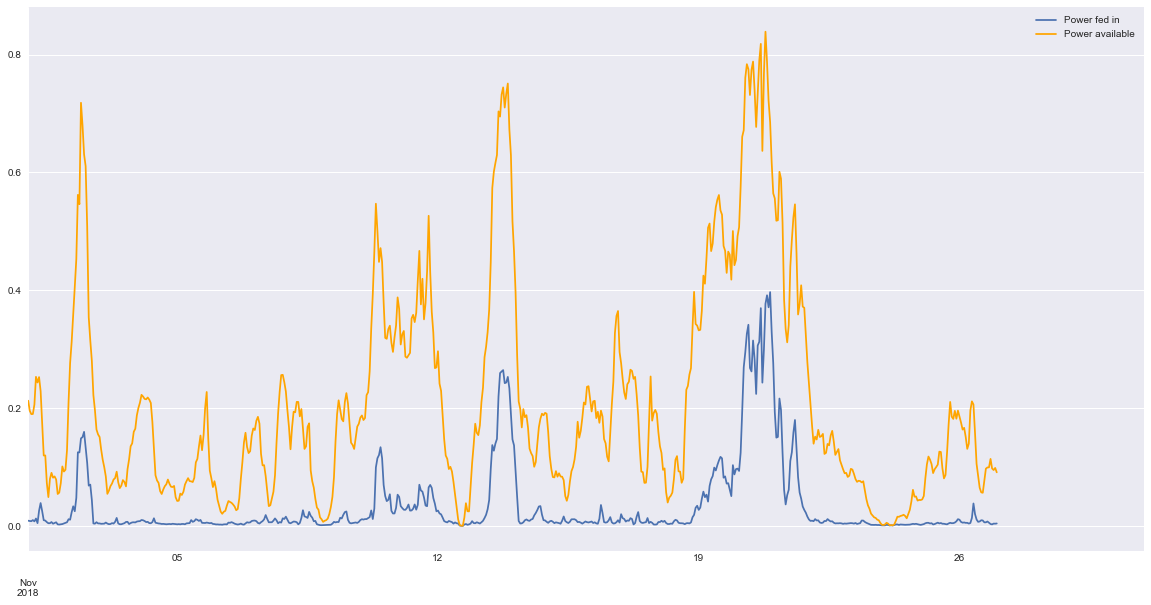

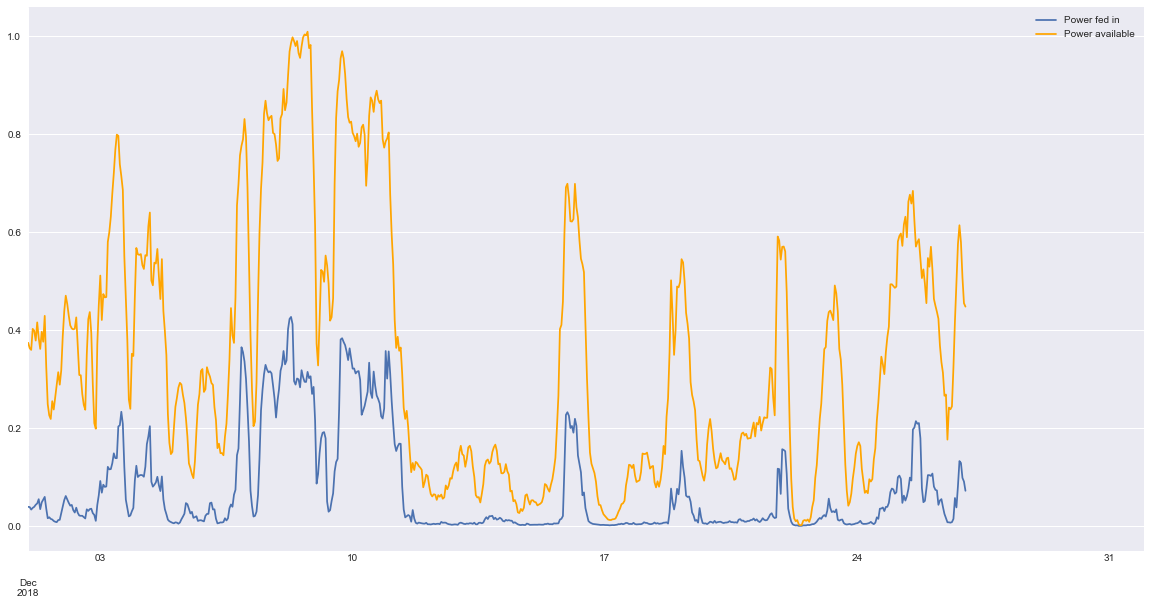

In [27]:
month = ['October','November', 'December'
        ]
for i in month:
    fig, ax = plt.subplots(figsize=(20,10))
    data = df.query('{} == 1'.format(i))
    avg_pow = data['target_losses_norm'].resample('H').mean()
    avg_pot = data['power_available_mw_obsnorm'].resample('H').mean()
    avg_pow.plot(label='Power fed in',color = 'b',legend=True)
    avg_pot.plot(label='Power available',color='orange',legend=True)
plt.show

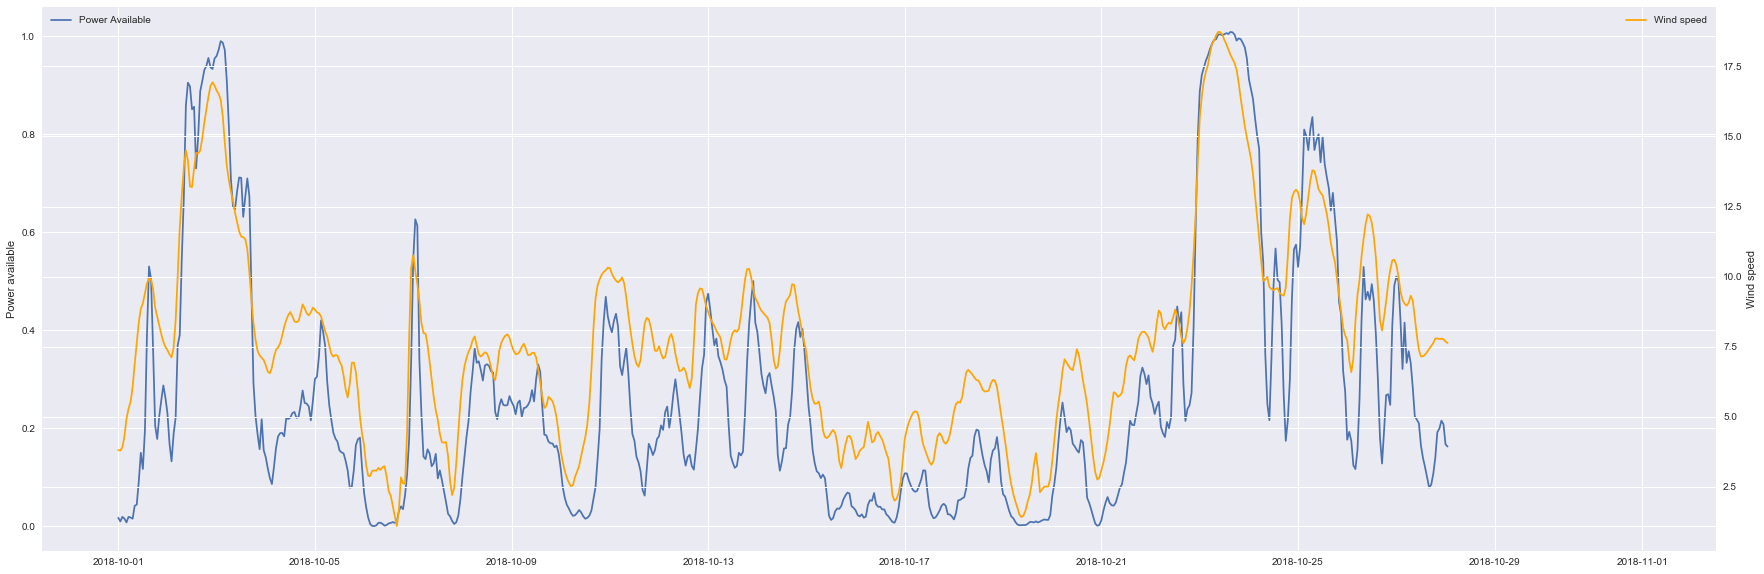

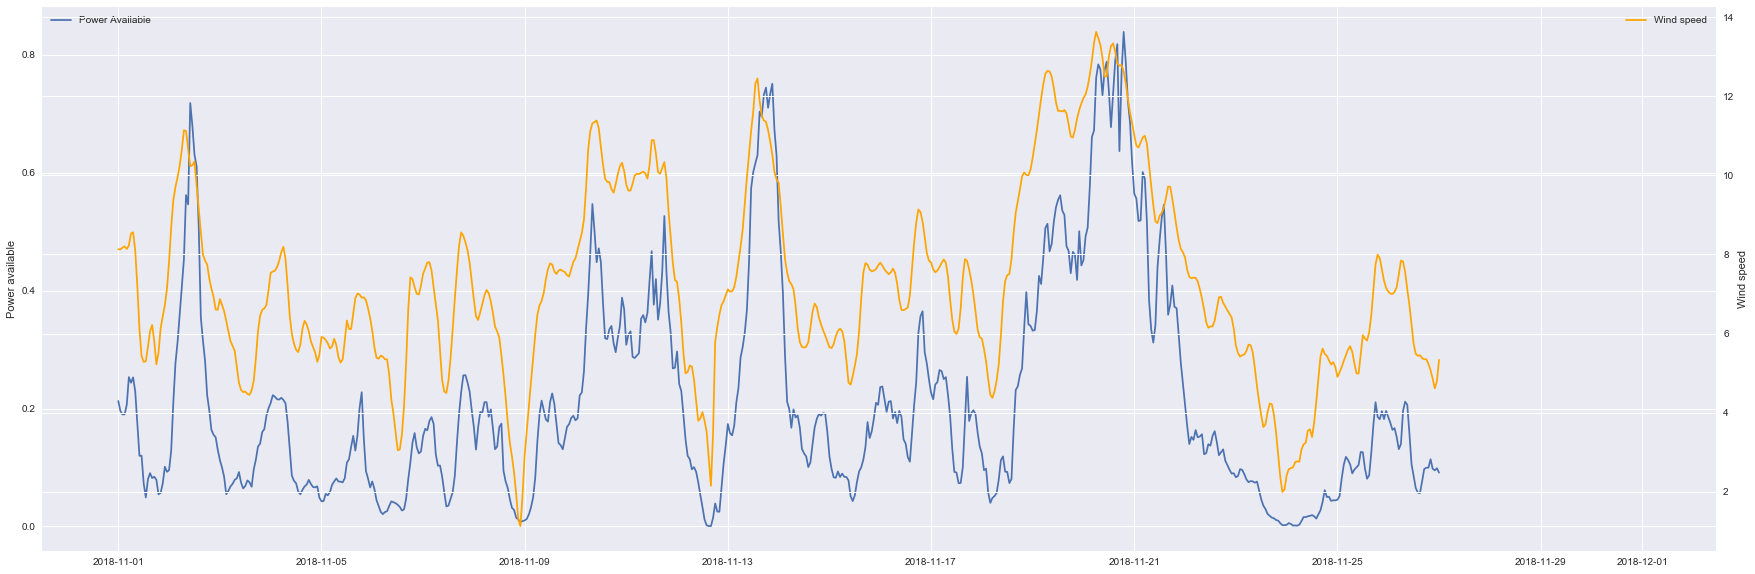

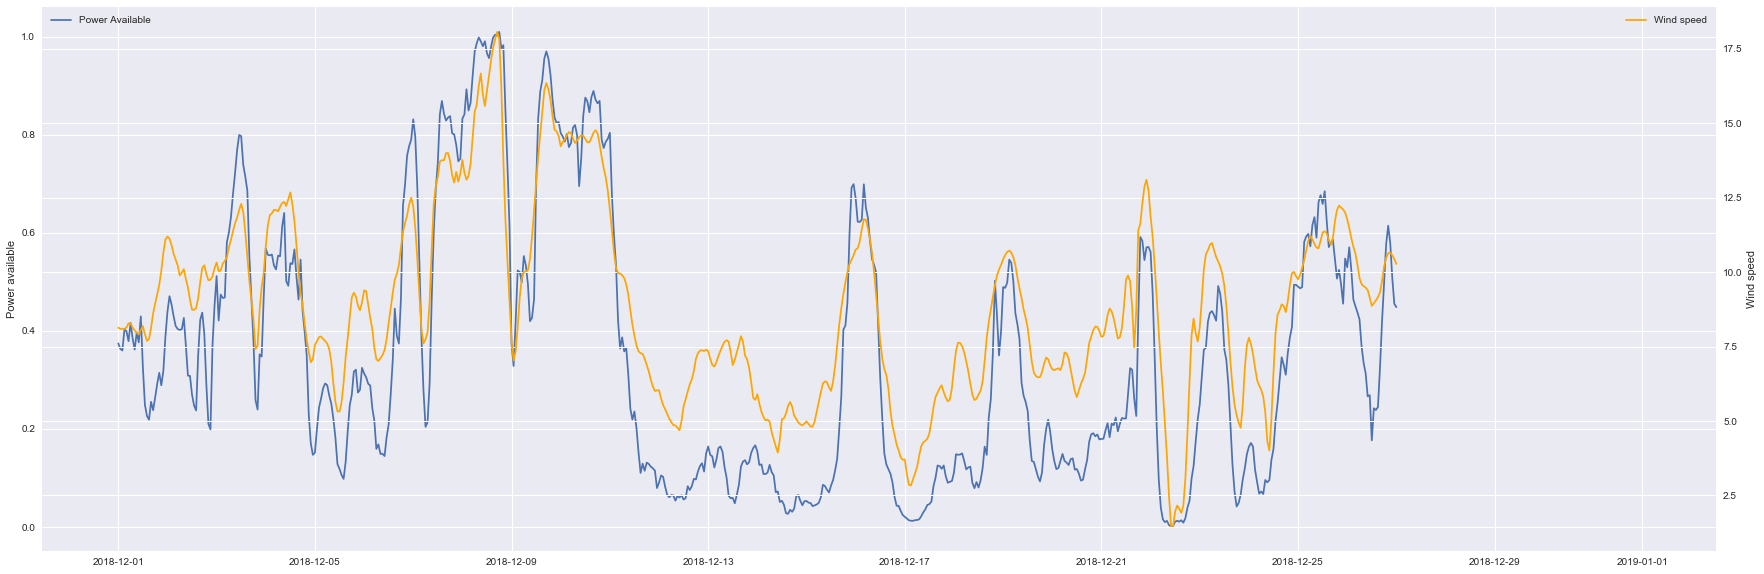

In [28]:
month = ['October','November','December'
        ]
for i in month:
    fig, ax1 = plt.subplots(figsize=(30,10))
    data = df.query('{} == 1'.format(i))
    avail = data['power_available_mw_obsnorm'].resample('H').mean()
    ax1.plot(avail,scalex='autoscale', label='Power Available')
    ax1.set_ylabel('Power available')
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    wsp = data['wsp_100m_ms'].resample('H').mean()
    ax2.set_ylabel('Wind speed')
    ax2.plot(wsp,color='orange', label='Wind speed')
    ax2.legend(loc='upper right')
plt.show()

In [29]:
df_month = pd.DataFrame(df['target_losses_norm'])
df_month['day'] = df_month.index.day
df_month['hour'] = df_month.index.hour
df_month


,target_losses_norm,day,hour
2018-01-01 06:00:00,0.425598,1,6
2018-01-01 06:10:00,0.404513,1,6
2018-01-01 06:20:00,0.405137,1,6
2018-01-01 06:30:00,0.481961,1,6
2018-01-01 06:40:00,0.497063,1,6
...,...,...,...
2019-06-25 01:10:00,0.026618,25,1
2019-06-25 01:20:00,0.033104,25,1
2019-06-25 01:30:00,0.031078,25,1
2019-06-25 01:40:00,0.030189,25,1


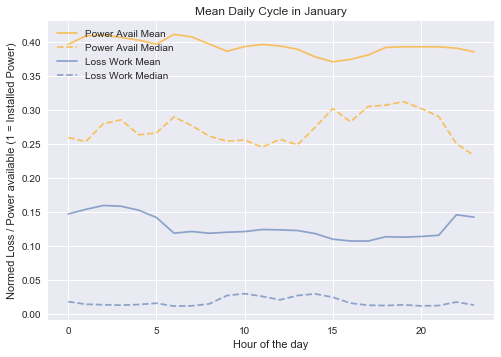

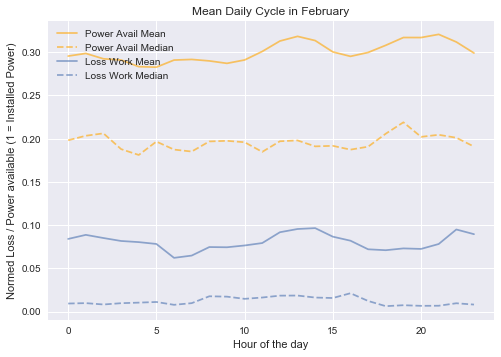

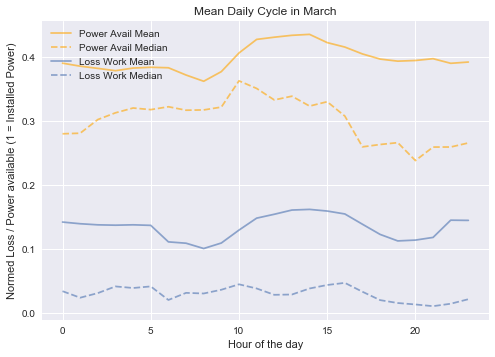

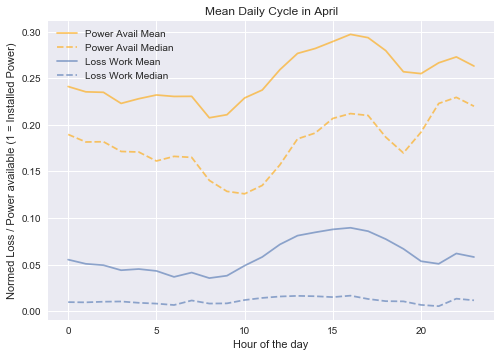

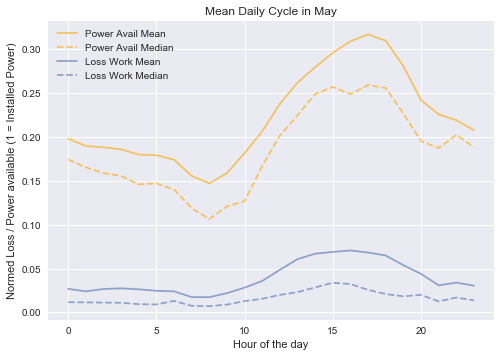

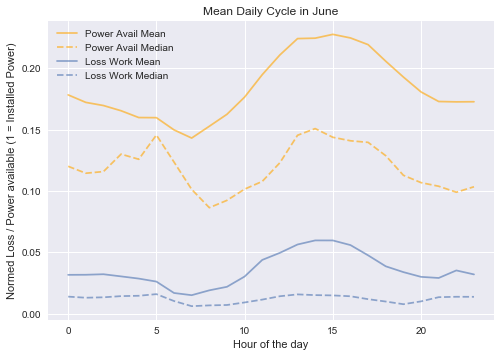

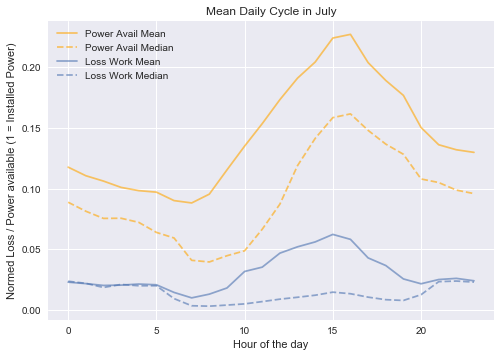

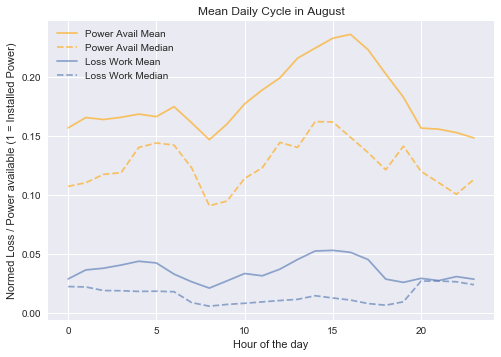

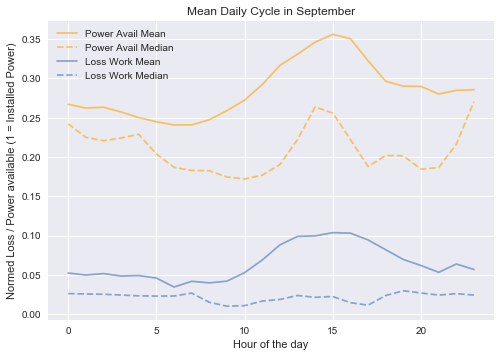

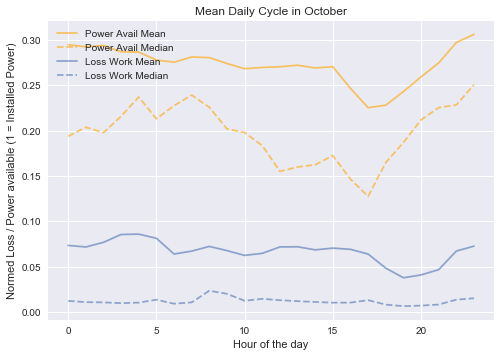

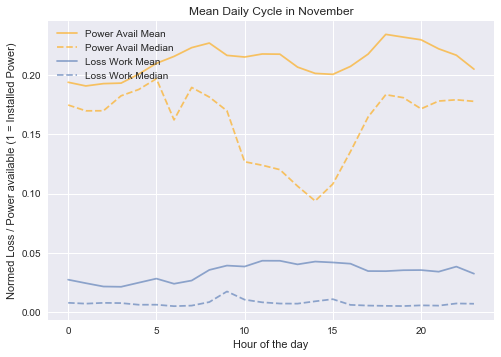

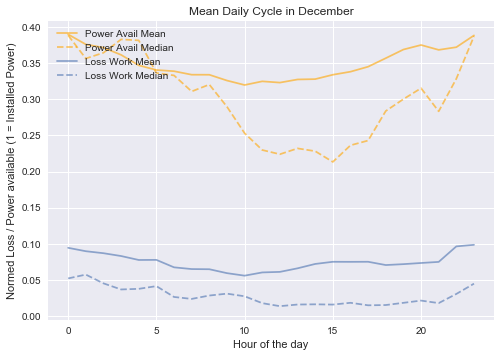

In [30]:
month=['January','February','March','April','May','June','July','August','September','October','November','December']
for i in month:
    # daily cycle
    plt.style.use('seaborn')
    data = df.query('{} == 1'.format(i))
    data.power_available_mw_obsnorm.groupby(data.index.hour).mean().plot(c='orange', alpha=0.6)
    data.power_available_mw_obsnorm.groupby(data.index.hour).median().plot(c='orange', linestyle='--', alpha=0.6)

    data.target_losses_norm.groupby(data.index.hour).mean().plot(c='b', alpha=0.6)
    data.target_losses_norm.groupby(data.index.hour).median().plot(c='b', linestyle='--', alpha=0.6)

    plt.legend(loc='upper left', labels=['Power Avail Mean', 'Power Avail Median',
                                         'Loss Work Mean', 'Loss Work Median'])
    plt.title('Mean Daily Cycle in {}'.format(i))
    plt.xlabel('Hour of the day')
    plt.ylabel('Normed Loss / Power available (1 = Installed Power)')
    plt.show()

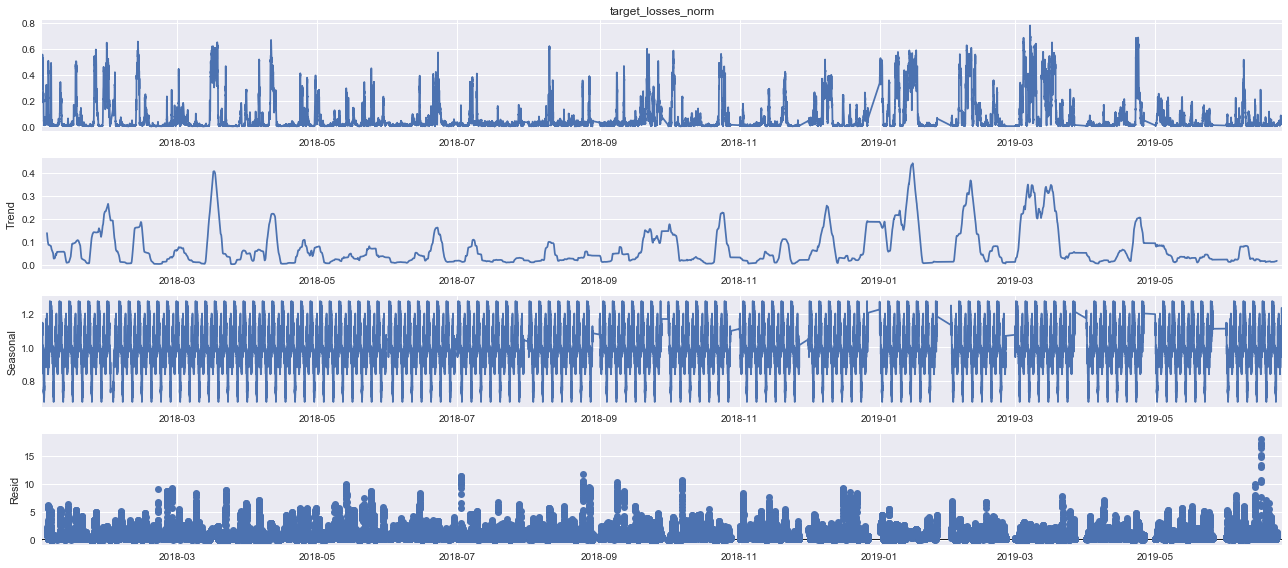

In [45]:
mlp.rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df['target_losses_norm'], model='multiplicative', period=600)
fig = decomposition.plot()
plt.show()

In [ ]:
month = ['October']
for i in month:
    fig, ax1 = plt.subplots(figsize=(30,10))
    data = df.query('{} == 1'.format(i))
    avail = data['target_losses_norm'].resample('H').mean()
    ax1.plot(avail,scalex='autoscale', label='EinsMan Losses')
    ax1.set_ylabel('EinsMan Losses')
    ax2 = ax1.twinx()
    wsp = data['wsp_100m_ms'].resample('H').mean()
    ax2.set_ylabel('Wind speed')
    ax2.plot(wsp,color='orange', label='Wind speed')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

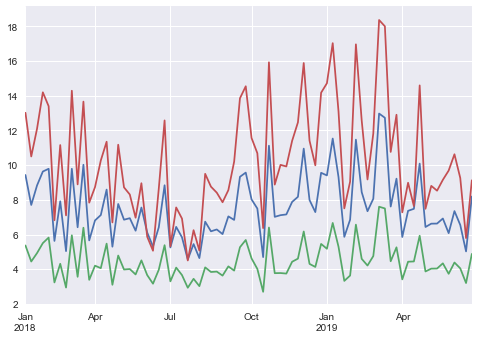

In [34]:
wsp = ['wsp_100m_ms','wsp_10m_ms','wsp_pl925_ms']
for i in wsp:
    avg_wsp = df[i].resample('W').mean()
    avg_wsp.plot()
plt.show

In [35]:
show_dist = ['dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa','pottemp_80mto0m_K', 'q_2m_1',
             'q_pfg30_1', 'r_pl925_perc','r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
             'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn','wdir_pl925_dn',
             'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms']

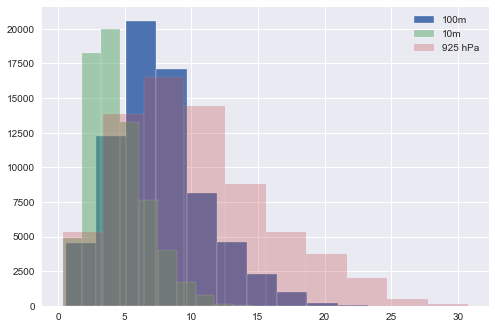

In [36]:
fig, ax = plt.subplots()
rects1 = ax.hist(x=df['wsp_100m_ms'],label='100m')
rects2 = ax.hist(x=df['wsp_10m_ms'],label='10m',alpha=0.5)
rects3 = ax.hist(x=df['wsp_pl925_ms'],label='925 hPa',alpha=0.3)
ax.legend()
plt.show()

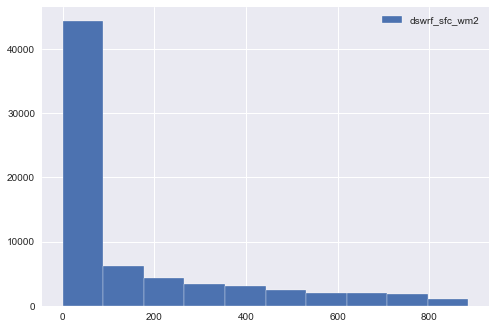

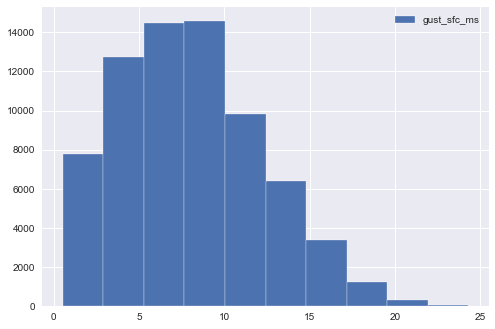

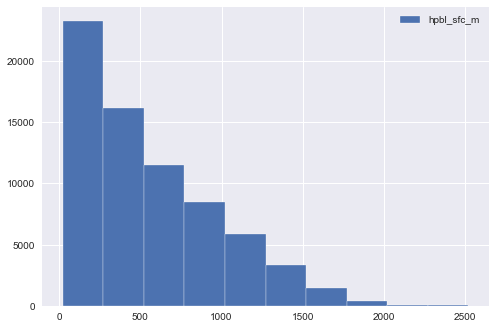

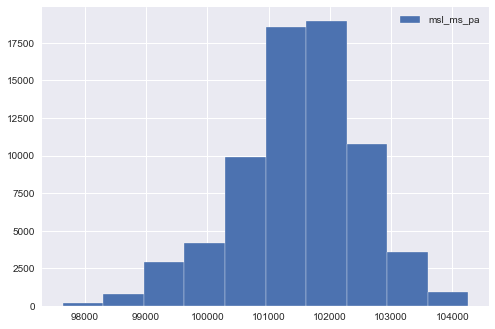

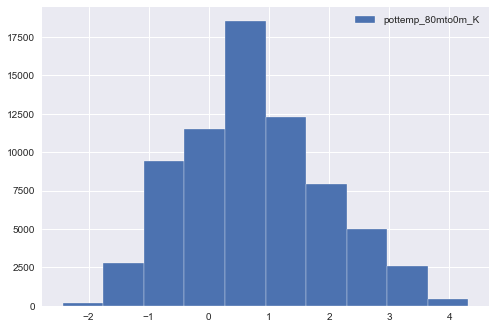

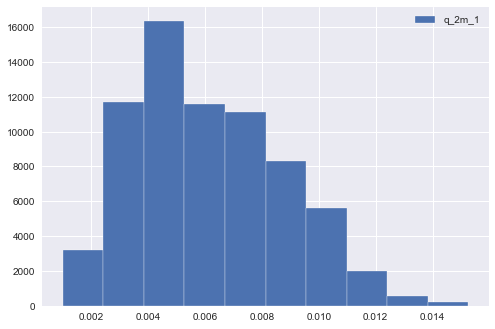

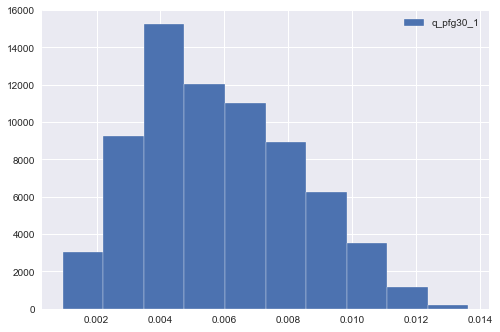

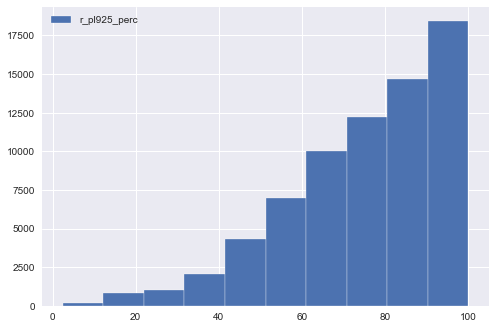

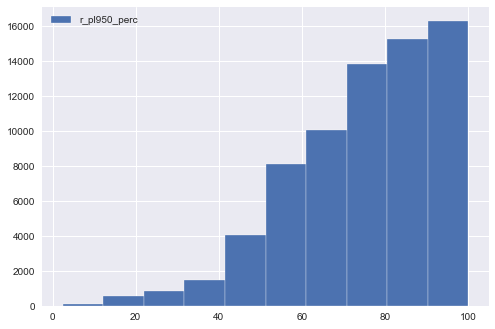

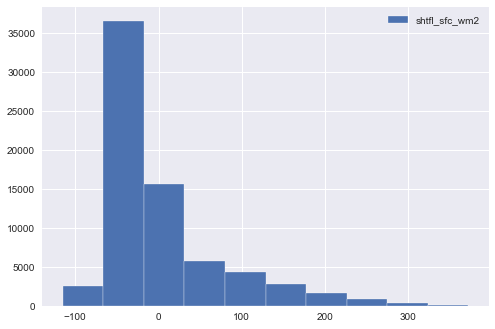

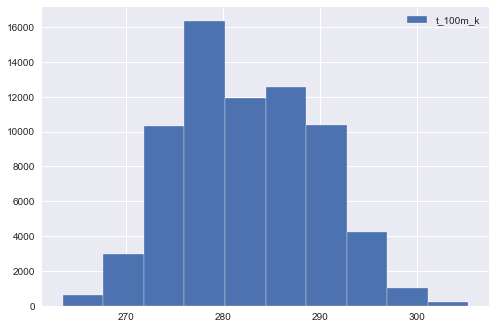

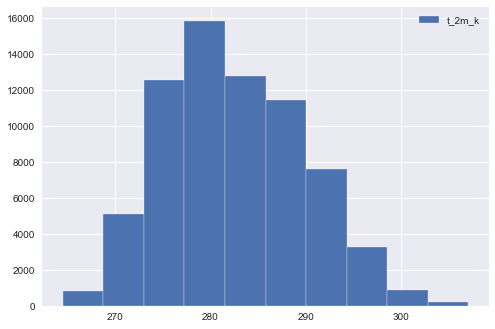

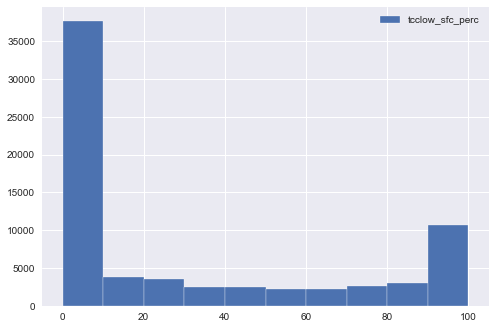

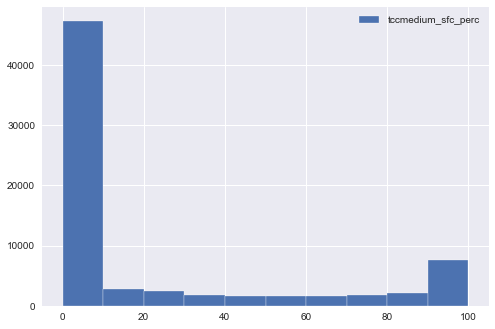

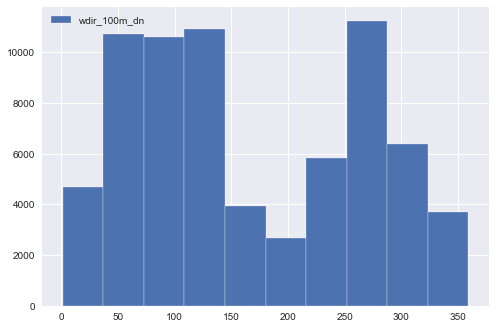

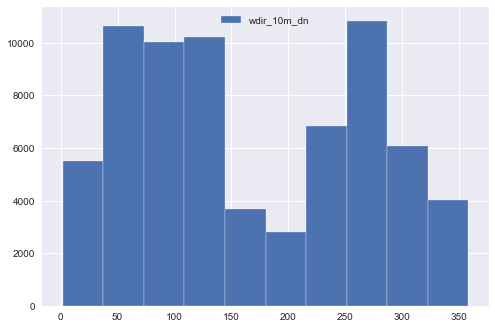

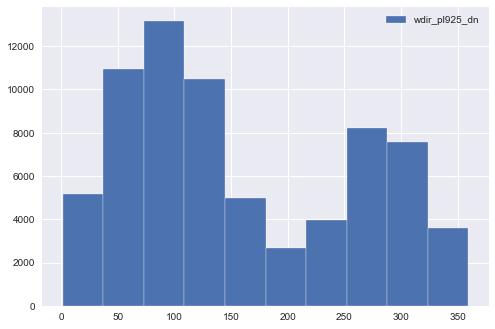

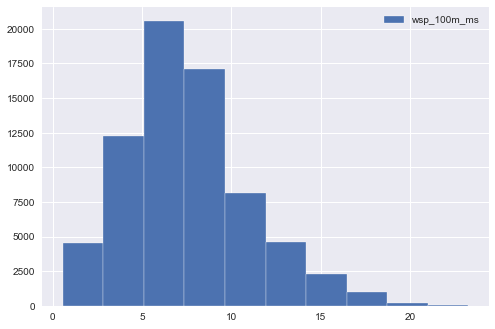

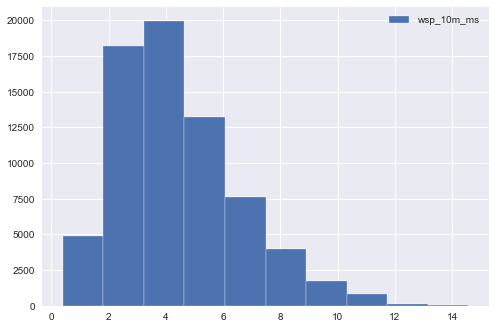

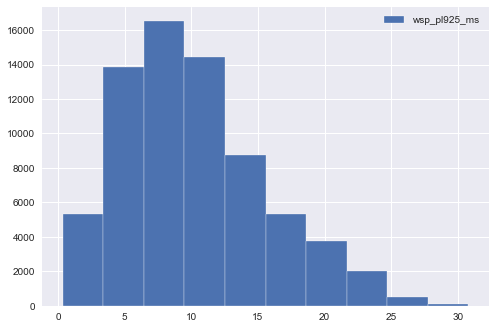

In [37]:
# distribution for each feature in base dataframe
for i in show_dist:
    fig, ax = plt.subplots()
    rects = ax.hist(x=df[i], label=i)
    ax.legend()
    plt.show()

In [ ]:
num_features = ['dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa','pottemp_80mto0m_K', 'q_2m_1',
             'q_pfg30_1', 'r_pl925_perc','r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
             'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn','wdir_pl925_dn',
             'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms']

In [ ]:
def preproc(x_train):
    min_max = preprocessing.MinMaxScaler()
    x_preproc = min_max.fit_transform(x_train)
    return pd.DataFrame(x_preproc, columns=x_train.columns, index=x_train.index)